In [1]:
import pandas as pd
import os
import numpy as np
import scipy
import math
import random
import sklearn
import nltk
import warnings
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
path="D:\\CDS513\\Assignment 1\\Data"
    
os.chdir(path)

# Read csv data file
# Data without feature standardization
df = pd.read_csv('Data_final_description.csv')

In [3]:
df

,Unnamed: 0,User-id,Game-title,Genre,personal-rating,description,Publisher
0,0,5250,Alien Swarm,Shooter,3,Alien Swarm is a game and Source SDK release f...,Valve
1,1,975449,Alien Swarm,Shooter,5,Alien Swarm is a game and Source SDK release f...,Valve
2,2,1950243,Alien Swarm,Shooter,3,Alien Swarm is a game and Source SDK release f...,Valve
3,3,2259650,Alien Swarm,Shooter,2,Alien Swarm is a game and Source SDK release f...,Valve
4,4,2753525,Alien Swarm,Shooter,2,Alien Swarm is a game and Source SDK release f...,Valve
...,...,...,...,...,...,...,...
43059,43059,287824954,Close Your Eyes,Puzzle,5,Close Your Eyes is a puzzle horror game where ...,Yai Gameworks
43060,43060,293303005,All Is Dust,Role-playing (RPG),5,Dust off the vacuum and tidy up with The Sims ...,Publisher not available
43061,43061,300248088,Sigils of Elohim,Puzzle,5,"As if awakening from a deep sleep, you find yo...",Devolver Digital
43062,43062,306839937,Secret Files Tunguska,Point-and-click,5,Unravel one of the greatest mysteries of our t...,Publisher not available


# Finding # of interaction

In [4]:
users_interactions_count_df = df.groupby(['User-id', 'Game-title']).size().groupby('User-id').size()
print('# users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5]\
                                    .reset_index()[['User-id']]


users_with_few_interactions_df = users_interactions_count_df[users_interactions_count_df < 3]\
                                    .reset_index()[['User-id']]

print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))
print('# users with less than 3 interactions: %d' % len(users_with_few_interactions_df))

# users: 8476
# users with at least 5 interactions: 1719
# users with less than 3 interactions: 5936


In [5]:
interactions_from_selected_users_df = df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'User-id',
               right_on = 'User-id')

interactions_from_few_selected_users_df = df.merge(users_with_few_interactions_df, 
               how = 'right',
               left_on = 'User-id',
               right_on = 'User-id')

print('# of interactions from all users: %d' % len(df))
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))
print('# of interactions from users with less than 3 interactions: %d' % len(interactions_from_few_selected_users_df))

# of interactions from all users: 43064
# of interactions from users with at least 5 interactions: 33275
# of interactions from users with less than 3 interactions: 6974


In [6]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['User-id', 'Game-title'])['personal-rating'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 32809


,User-id,Game-title,personal-rating
0,76767,Age of Empires II HD Edition,1.584963
1,76767,Call of Duty Black Ops,2.584963
2,76767,Call of Duty Modern Warfare 2,2.584963
3,76767,Call of Duty Modern Warfare 3,2.000000
4,76767,Call of Duty World at War,2.584963
5,76767,Counter-Strike,2.584963
6,76767,Counter-Strike Global Offensive,1.000000
7,76767,Counter-Strike Source,1.000000
8,76767,Portal 2,2.321928
9,76767,Rise of Nations Extended Edition,2.000000


# Split Dataset for training and testing

In [7]:
interactions_train_df, interactions_test_df = train_test_split(interactions_from_selected_users_df,
                                   stratify=interactions_from_selected_users_df['User-id'],
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 26620
# interactions on Test set: 6655


In [8]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_from_selected_users_df.set_index('User-id')
interactions_train_indexed_df = interactions_train_df.set_index('User-id')
interactions_test_indexed_df = interactions_test_df.set_index('User-id')

In [9]:
def get_items_interacted(UserID, interactions_df):
    # Get the user's data and merge in the game information.
    interacted_items = interactions_df.loc[UserID]['Game-title']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

# Top-N accuracy metrics

In [10]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(df['Game-title'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, UserID):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[UserID]
        if type(interacted_values_testset['Game-title']) == pd.Series:
            user_interacted_items_testset = set(interacted_values_testset['Game-title'])
        else:
            user_interacted_items_testset = set(interacted_values_testset['Game-title'])
        interacted_items_count_testset = len(user_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        user_recs_df = model.recommend_items(UserID, 
                                               items_to_ignore=get_items_interacted(UserID, 
                                                                                    interactions_train_indexed_df), 
                                                                                    topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in user_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(UserID, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = user_recs_df[user_recs_df['Game-title'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['Game-title'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        user_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return user_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, UserID in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            user_metrics = self.evaluate_model_for_user(model, UserID)  
            user_metrics['UserID'] = UserID
            people_metrics.append(user_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

# Content-based Filtering model

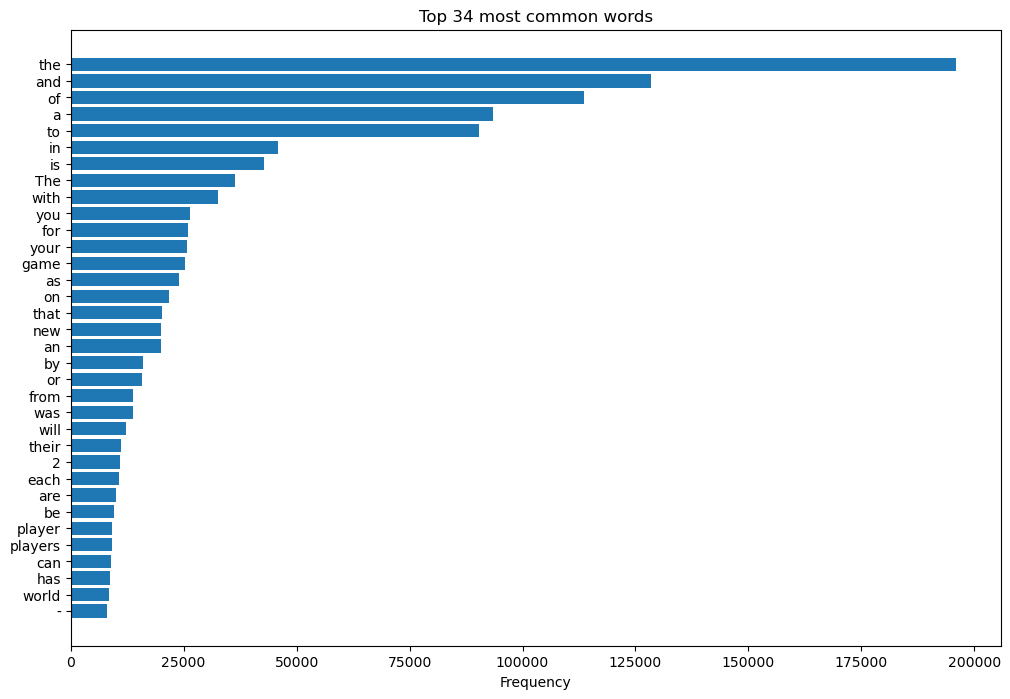

[('the', 196032), ('and', 128407), ('of', 113577), ('a', 93456), ('to', 90425), ('in', 45924), ('is', 42814), ('The', 36262), ('with', 32501), ('you', 26405), ('for', 26006), ('your', 25737), ('game', 25273), ('as', 24039), ('on', 21856), ('that', 20191), ('new', 20036), ('an', 19885), ('by', 15967), ('or', 15879), ('from', 13799), ('was', 13786), ('will', 12132), ('their', 11100), ('2', 10825), ('each', 10705), ('are', 10000), ('be', 9674), ('player', 9204), ('players', 9083), ('can', 8965), ('has', 8669), ('world', 8534), ('-', 8071)]


In [11]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopwords_list = list(ENGLISH_STOP_WORDS)
# Analyze text data
text_data = df['description'].dropna().tolist()
words = [word for doc in text_data for word in doc.split()]
word_freq = Counter(words)

# Plot the most common words
common_words = word_freq.most_common(34)
words, counts = zip(*common_words)
plt.figure(figsize=(12, 8))
plt.barh(words, counts)
plt.xlabel('Frequency')
plt.title('Top 34 most common words')
plt.gca().invert_yaxis()
plt.show()

print(common_words)

In [12]:
most_common_words = [word for word, count in common_words]
stopwords_list.extend(most_common_words)
stopwords_list

['fill',
 'co',
 'somewhere',
 'only',
 'more',
 'be',
 'indeed',
 'could',
 'she',
 'will',
 'many',
 'becomes',
 'very',
 'amongst',
 'done',
 'call',
 'next',
 'whoever',
 'three',
 'though',
 'its',
 'even',
 'four',
 'has',
 'nowhere',
 'something',
 'thick',
 'around',
 'twelve',
 'onto',
 'one',
 'he',
 'each',
 'whom',
 'few',
 'off',
 'see',
 'who',
 'whose',
 'been',
 'whatever',
 'yourself',
 'above',
 'your',
 'thin',
 'go',
 'that',
 'seeming',
 'twenty',
 'thereby',
 'both',
 'every',
 'noone',
 'here',
 'almost',
 'give',
 'down',
 'their',
 'sometime',
 'latterly',
 'rather',
 'cant',
 'please',
 'if',
 'ourselves',
 'found',
 'con',
 'so',
 'herein',
 'sometimes',
 'into',
 'with',
 'sincere',
 'were',
 'detail',
 'empty',
 'latter',
 'whereas',
 'mine',
 'should',
 'well',
 'made',
 'whenever',
 'how',
 'over',
 'nevertheless',
 'am',
 'everything',
 'no',
 'thus',
 'either',
 'most',
 'others',
 'and',
 'always',
 'nobody',
 'before',
 'hundred',
 'during',
 'someone

In [13]:
#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.9,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = df['Game-title'].tolist()
tfidf_matrix = vectorizer.fit_transform(df['description']+df['Game-title'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<43064x4533 sparse matrix of type '<class 'numpy.float64'>'
	with 2171870 stored elements in Compressed Sparse Row format>

#### 

In [14]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['Game-title'])
    user_item_strengths = np.array(interactions_person_df['personal-rating']).reshape(-1, 1)    
    # Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    # Convert to numpy array and ensure 2D shape
    user_item_strengths_weighted_avg = np.asarray(user_item_strengths_weighted_avg).reshape(1, -1)
    # Normalize
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)    
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['Game-title'] \
                                                   .isin(df['Game-title'])].set_index('User-id')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [15]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
user_profiles = build_users_profiles()
len(user_profiles)

1719

In [16]:
user_game_counts = df.groupby('User-id')['Game-title'].count().reset_index()
user_game_counts.columns = ['User-id', 'Game-title-count']

print(user_game_counts.head())

max_games_user = user_game_counts.loc[user_game_counts['Game-title-count'].idxmax()]
print("User with the most game titles:")
print(max_games_user)

   User-id  Game-title-count
0     5250                 4
1    76767                12
2    86540                 8
3   229911                 7
4   298950                96
User with the most game titles:
User-id             62990992
Game-title-count         312
Name: 1212, dtype: int64


In [17]:
myprofile = user_profiles[62990992]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[62990992].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 4533)


,token,relevance
0,war,0.140631
1,story,0.131823
2,games,0.121522
3,puzzle,0.114409
4,levels,0.113489
5,battle,0.112330
6,rpg,0.108683
7,evil,0.108539
8,action,0.104476
9,use,0.103042


# Content-Based Recommender Class

In [18]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME

    def getUniqueList(self,similar_items):
        # Retaining only unique sets of item
        seen = set()
        unique_similar_items = []
        for item in similar_items:
            if item not in seen:
                unique_similar_items.append(item)
                seen.add(item)
        
        return unique_similar_items

    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        if person_id not in user_profiles:
            return []
        # Computes the cosine similarity between the user profile and all item profiles
        user_profile = user_profiles[person_id]
        cosine_similarities = cosine_similarity(user_profile, tfidf_matrix)
        # Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        # Sort the similar items by similarity
        similar_items = sorted([(self.item_ids[i], cosine_similarities[0, i]) for i in similar_indices], \
                               key=lambda x: -x[1])
        
        similar_items = self.getUniqueList(similar_items)
        
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=1000000000, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['Game-title', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Game-title', 
                                                          right_on = 'Game-title')[['recStrength', \
                                                                                   'Game-title', \
                                                                                   'Genre', \
                                                                                   'description']]
            
        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(df)

In [19]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...


C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

1718 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.017118630509559234, 'recall@10': 0.01743860491160707}


C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,UserID
28,2,4,63,0.031746,0.063492,62990992
1,4,4,50,0.080000,0.080000,138941587
508,3,3,37,0.081081,0.081081,11403772
199,0,0,36,0.000000,0.000000,49893565
414,3,3,36,0.083333,0.083333,48798067
282,3,3,35,0.085714,0.085714,24469287
314,1,1,32,0.031250,0.031250,116876958
294,4,4,31,0.129032,0.129032,47457723
316,1,1,29,0.034483,0.034483,11373749
50,3,3,28,0.107143,0.107143,10599862


# Collaborative Filtering model

## Matrix Factorization

In [20]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_full_df.pivot(index='User-id', 
                                                          columns='Game-title', 
                                                          values='personal-rating').fillna(0)

users_items_pivot_matrix_df

Game-title,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,140,16bit Trader,18 Wheels of Steel American Long Haul,...,eden*,fault milestone one,iBomber Defense,iBomber Defense Pacific,ibb & obb,rFactor,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,theHunter,theHunter Primal
User-id,,,,,,,,,,,,,,,,,,,,,
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
554278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285869008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286926470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288274882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[76767,
 86540,
 229911,
 298950,
 554278,
 561758,
 748719,
 975449,
 1129452,
 1612666]

In [23]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1719x2530 sparse matrix of type '<class 'numpy.float64'>'
	with 32809 stored elements in Compressed Sparse Row format>

In [24]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [25]:
U.shape

(1719, 15)

In [26]:
Vt.shape

(15, 2530)

In [27]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [28]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.0359413 , -0.00063348,  0.01376099, ..., -0.01295782,
         0.01206941,  0.00597727],
       [-0.00559634, -0.00192065,  0.00195497, ..., -0.01953056,
        -0.03683172, -0.00098641],
       [ 0.02274207, -0.00205188,  0.01007731, ..., -0.01422782,
         0.01468545,  0.00522858],
       ...,
       [ 0.00573725,  0.00067547,  0.00053464, ..., -0.01290819,
         0.06175388,  0.00484437],
       [ 0.0174285 ,  0.00096143, -0.00462627, ...,  0.05134612,
         0.02717364,  0.00592032],
       [ 0.00131777,  0.00312128, -0.01111642, ..., -0.01430644,
         0.09600115,  0.01036785]])

In [29]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [30]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,76767,86540,229911,298950,554278,561758,748719,975449,1129452,1612666,...,281535206,282464648,283872900,285386664,285860790,285869008,286926470,288274882,293042025,294620986
Game-title,,,,,,,,,,,,,,,,,,,,,
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),0.333915,0.328936,0.332332,0.324684,0.329809,0.342768,0.324082,0.344587,0.328451,0.327788,...,0.327666,0.330197,0.326612,0.330524,0.327244,0.328144,0.329687,0.330294,0.331696,0.329765
10 Second Ninja,0.329531,0.329376,0.329361,0.330461,0.329669,0.329429,0.329937,0.329240,0.330098,0.329331,...,0.330351,0.329634,0.329472,0.329458,0.329396,0.329692,0.329614,0.329688,0.329722,0.329981
"10,000,000",0.331256,0.329841,0.330814,0.332830,0.329959,0.333787,0.328865,0.335272,0.329991,0.330089,...,0.329653,0.330062,0.329683,0.329693,0.330723,0.329372,0.329501,0.329671,0.329052,0.328274
100% Orange Juice,0.328512,0.330116,0.328437,0.330176,0.329665,0.327532,0.329936,0.328199,0.329037,0.330232,...,0.330297,0.329727,0.329693,0.329588,0.329189,0.329736,0.329466,0.329754,0.330646,0.330529
12 Labours of Hercules,0.330992,0.332053,0.328226,0.320681,0.329269,0.329553,0.331652,0.337097,0.329419,0.332729,...,0.329818,0.329463,0.334758,0.329841,0.335645,0.331057,0.331005,0.331274,0.330237,0.328533
12 Labours of Hercules II The Cretan Bull,0.329944,0.331659,0.326222,0.327384,0.329300,0.330489,0.329697,0.335847,0.327781,0.332503,...,0.327883,0.329645,0.330096,0.329715,0.333255,0.330160,0.331171,0.330611,0.328120,0.328753
12 Labours of Hercules III Girl Power,0.329249,0.332632,0.328195,0.317078,0.329091,0.330572,0.329731,0.335432,0.330513,0.329811,...,0.328954,0.329510,0.331826,0.329441,0.332766,0.330250,0.330928,0.330972,0.329030,0.328903
140,0.329955,0.329354,0.329697,0.329322,0.329492,0.329710,0.329401,0.330221,0.329371,0.329622,...,0.329609,0.329596,0.329767,0.329814,0.329502,0.329568,0.329613,0.329667,0.329794,0.329565
16bit Trader,0.328343,0.329974,0.326270,0.324276,0.331234,0.329085,0.330164,0.339482,0.329592,0.332247,...,0.328642,0.328756,0.330579,0.329140,0.334501,0.330242,0.331115,0.329251,0.328329,0.327971


In [31]:
len(cf_preds_df.columns)

1719

In [32]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['Game-title'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Game-title', 
                                                          right_on = 'Game-title')[['recStrength', \
                                                                                    'Game-title', \
                                                                                    'Genre', \
                                                                                   'description']]

        #return self.items_df
        return recommendations_df.drop_duplicates()
    
cf_recommender_model = CFRecommender(cf_preds_df, df)

In [33]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...


C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

1718 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3394928405727542, 'recall@10': 0.3952483801295896}


C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,UserID
28,61,61,63,0.968254,0.968254,62990992
1,49,49,50,0.980000,0.980000,138941587
508,27,29,37,0.729730,0.783784,11403772
199,35,35,36,0.972222,0.972222,49893565
414,33,35,36,0.916667,0.972222,48798067
282,32,33,35,0.914286,0.942857,24469287
314,15,18,32,0.468750,0.562500,116876958
294,16,18,31,0.516129,0.580645,47457723
316,23,26,29,0.793103,0.896552,11373749
50,23,25,28,0.821429,0.892857,10599862


In [34]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'Game-title', 
                                   right_on = 'Game-title').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Game-title', 
                                                          right_on = 'Game-title')[['recStrengthHybrid', \
                                                                                   'Game-title', \
                                                                                   'Genre', \
                                                                                   'description']]


        return recommendations_df.drop_duplicates()
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, df,\
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

In [35]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


Evaluating Hybrid model...


C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

1718 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.3402127829773618, 'recall@10': 0.396528277737781}


C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28436\1162594667.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,UserID
28,61,61,63,0.968254,0.968254,62990992
1,49,49,50,0.980000,0.980000,138941587
508,27,29,37,0.729730,0.783784,11403772
199,35,35,36,0.972222,0.972222,49893565
414,34,35,36,0.944444,0.972222,48798067
282,31,33,35,0.885714,0.942857,24469287
314,15,18,32,0.468750,0.562500,116876958
294,16,18,31,0.516129,0.580645,47457723
316,23,26,29,0.793103,0.896552,11373749
50,23,24,28,0.821429,0.857143,10599862


## Comparing the methods

In [36]:
global_metrics_df = pd.DataFrame([cb_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.017119,0.017439
Collaborative Filtering,0.339493,0.395248
Hybrid,0.340213,0.396528


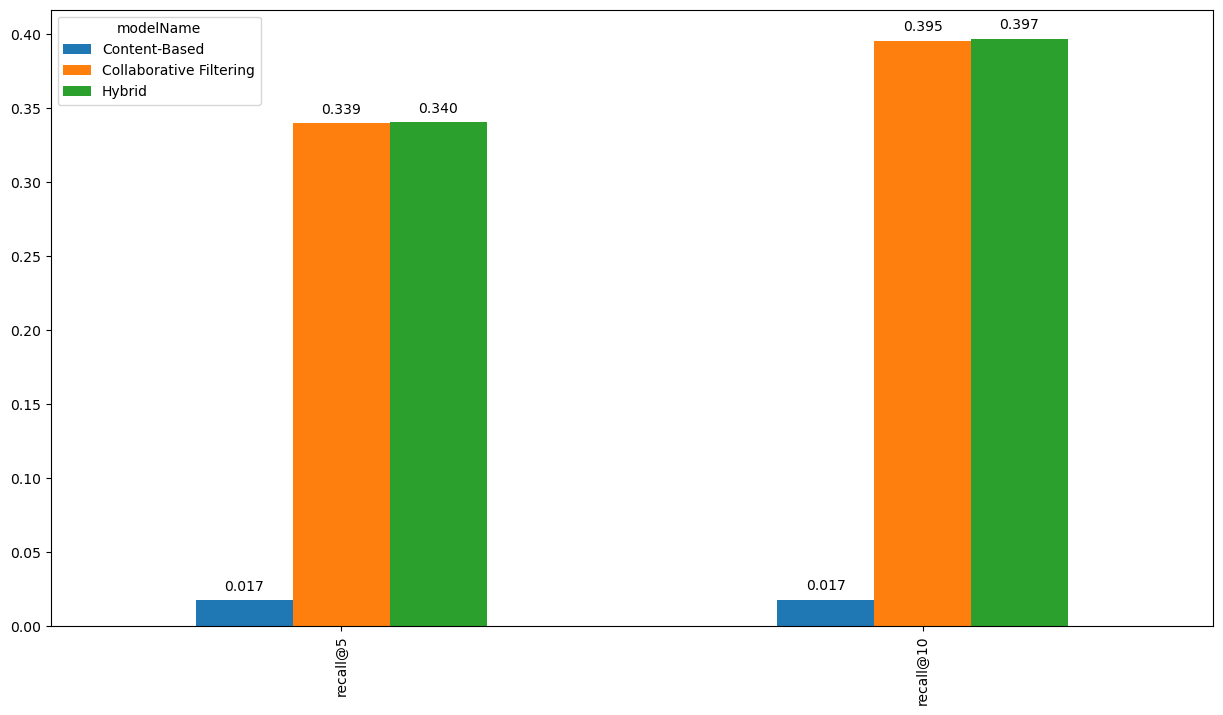

In [37]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Testing

In [38]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id]

In [39]:
inspect_interactions(62990992, test_set=False).head(20)

,Unnamed: 0,Game-title,Genre,personal-rating,description,Publisher
User-id,,,,,,
62990992,28131,Euro Truck Simulator 2,Simulator,1,This version includes the base game plus 25 DLC.,Publisher not available
62990992,34580,Ionball 2 Ionstorm,Arcade,4,IonBall 2: Ionstorm is an arcade game with a m...,Publisher not available
62990992,41498,Merchants of Kaidan,Role-playing (RPG),5,Merchants of Kaidan is a challenging trading g...,Forever Entertainment S. A.
62990992,24931,Supreme Commander 2,Real Time Strategy (RTS),2,Supreme Commander 2 is a real-time strategy (R...,Square Enix
62990992,40031,Age of Empires Online,Real Time Strategy (RTS),5,Age of Empires Online is a multiplayer online ...,Publisher not available
62990992,38253,E.Y.E Divine Cybermancy,Shooter,5,"In a dark Cyberpunk world, you (and up to 3 fr...",Publisher not available
62990992,30166,Anomaly Warzone Earth,Real Time Strategy (RTS),4,Anomaly Warzone Earth is an extraordinary mixt...,Publisher not available
62990992,41593,The Samaritan Paradox,Point-and-click,5,A writer has died. His daughter seeks the help...,Screen 7
62990992,17426,Sniper Elite V2,Shooter,4,Sniper Elite V2 is the eagerly-awaited sequel ...,Rebellion Developments


In [40]:
hybrid_recommender_model.recommend_items(62990992, topn=20, verbose=True)

,recStrengthHybrid,Game-title,Genre,Publisher,description
0,77.623388,Torchlight II,Role-playing (RPG),Runic Games,Torchlight II features randomly generated dung...
352,76.011016,Total War ROME II - Emperor Edition,Real Time Strategy (RTS),Publisher not available,The Emperor Edition is the definitive edition ...
494,75.579719,Total War SHOGUN 2,Strategy,Publisher not available,Bolster your Sengoku-era forces with Saints an...
651,75.389439,Counter-Strike Global Offensive,Shooter,Valve,Counter-Strike: Global Offensive expands upon ...
1916,74.903279,Dead Island,Shooter,Deep Silver,The player is drawn into the world of Dead Isl...
2048,74.757085,Empire Total War,Real Time Strategy (RTS),Publisher not available,Empire: Total War introduces a host of revolut...
2224,74.356160,Portal 2,Shooter,Publisher not available,"Get Portalâ¢2 In Motionâ¢, Adventure, Puzzle..."
2612,73.716965,Orcs Must Die! 2,Shooter,Robot Entertainment,Orcs Must Die! 2 thrusts players and their fri...
2683,71.483028,PAYDAY The Heist,Shooter,Publisher not available,Payday: The Heist is an action filled first pe...
2811,70.476554,Saints Row IV,Shooter,Deep Silver,"Unlike the first three games in the franchise,..."
